<a href="https://colab.research.google.com/github/mostakimjihad/EnFER-ViT/blob/main/EnFER_Vit(RAF_DB_%26_FER2013).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EnFER-ViT

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Add


efficientnet = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

for layer in efficientnet.layers[-20:]:
    layer.trainable = True

def transformer_encoder(inputs, num_heads=4, key_dim=32, ff_dim=128, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn_output = Dropout(dropout)(ffn)
    out2 = Add()([out1, ffn_output])
    return LayerNormalization(epsilon=1e-6)(out2)


input_tensor = Input(shape=(100, 100, 3))
efficientnet_features = Flatten()(efficientnet(input_tensor))

combined_features = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(efficientnet_features)
combined_features = Dropout(0.2)(BatchNormalization()(combined_features))

sequence_length = 8
embedding_dim = combined_features.shape[-1] // sequence_length
reshaped_features = Reshape((sequence_length, embedding_dim))(combined_features)


transformer_output = transformer_encoder(reshaped_features, num_heads=4, key_dim=embedding_dim, ff_dim=128, dropout=0.1)
pooled_output = GlobalAveragePooling1D()(transformer_output)


output_tensor = Dense(7, activation='softmax')(pooled_output)


model = Model(inputs=input_tensor, outputs=output_tensor)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb4            │ (None, 4, 4, 1792)     │     17,673,823 │ input_layer_1[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 28672)          │              0 │ efficientnetb4[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │     14,680,576 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8, 64)          │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 8, 64)          │         66,368 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 8, 64)          │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 64)          │              0 │ reshape[0][0],         │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 8, 64)          │            128 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 8, 128)         │          8,320 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8, 64)          │          8,256 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 8, 64)          │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 8, 64)          │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 8, 64)          │            128 │ add_1[0][0]            │
│ (LayerNormalization) 

 Total params: 32,440,102 (123.75 MB)

 Trainable params: 32,313,871 (123.27 MB)

 Non-trainable params: 126,231 (493.09 KB)

# **RAF-DB** Dataset From kaggle API

In [ ]:
import kagglehub

RAF_DB_DATASET_PATH = kagglehub.dataset_download("shuvoalok/raf-db-dataset")
print(RAF_DB_DATASET_PATH)

100%|██████████| 37.7M/37.7M [00:02<00:00, 13.3MB/s]

Extracting files...


/root/.cache/kagglehub/datasets/shuvoalok/raf-db-dataset/versions/2


## Data Pre-Processing for (RAF-DB)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = RAF_DB_DATASET_PATH + '/DATASET//train'
test_path = RAF_DB_DATASET_PATH + '/DATASET//test'

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    rotation_range=20
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1/255.0)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

Found 12271 images belonging to 7 classes.
Found 3068 images belonging to 7 classes.


## LBP

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

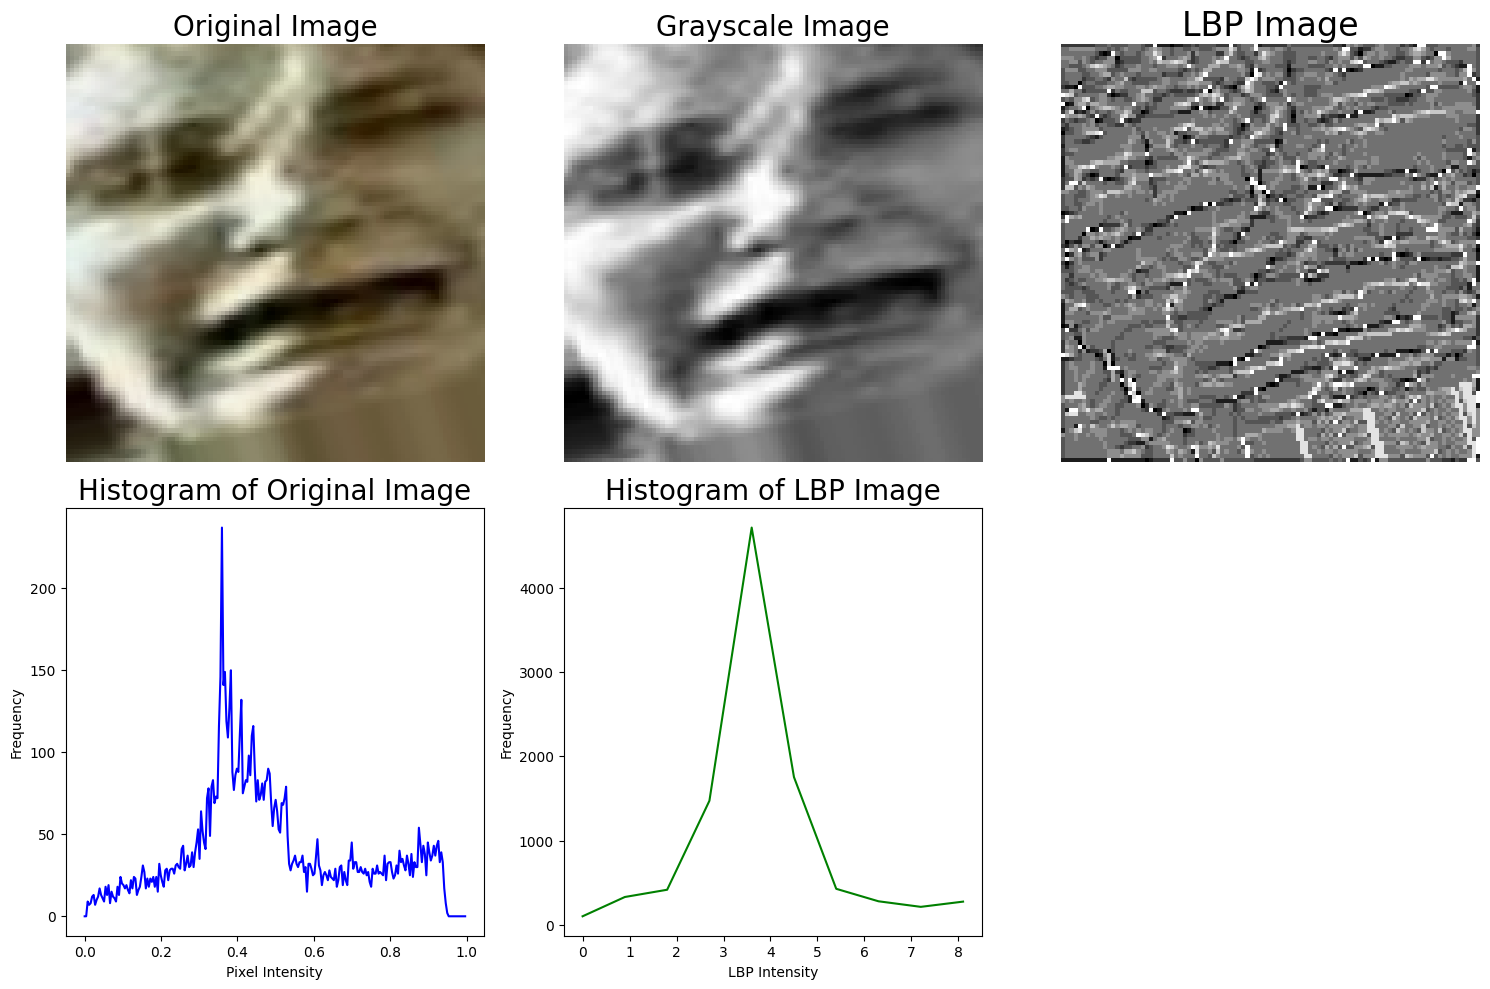

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
import random
import cv2
import google.colab.files as files

radius = 1
n_points = 8 * radius
method = 'uniform'

batch_images, batch_labels = next(train_generator)

random_index = random.randint(0, batch_images.shape[0] - 1)
random_image = batch_images[random_index]

gray_image = rgb2gray(random_image)

lbp_image = local_binary_pattern(gray_image, n_points, radius, method)

original_hist, original_bins = np.histogram(gray_image.ravel(), bins=256, range=(0, 1))
lbp_hist, lbp_bins = np.histogram(lbp_image.ravel(), bins=int(lbp_image.max() + 1), range=(0, lbp_image.max()))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(random_image)
axes[0, 0].set_title("Original Image", fontsize=20)
axes[0, 0].axis('off')


axes[0, 1].imshow(gray_image, cmap='gray')
axes[0, 1].set_title("Grayscale Image", fontsize=20)
axes[0, 1].axis('off')

axes[0, 2].imshow(lbp_image, cmap='gray')
axes[0, 2].set_title("LBP Image", fontsize=24)
axes[0, 2].axis('off')

axes[1, 0].plot(original_bins[:-1], original_hist, color='blue')
axes[1, 0].set_title("Histogram of Original Image", fontsize=20)
axes[1, 0].set_xlabel("Pixel Intensity")
axes[1, 0].set_ylabel("Frequency")

axes[1, 1].plot(lbp_bins[:-1], lbp_hist, color='green')
axes[1, 1].set_title("Histogram of LBP Image", fontsize=20)
axes[1, 1].set_xlabel("LBP Intensity")
axes[1, 1].set_ylabel("Frequency")

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('lbp.pdf')
files.download('lbp.pdf')
plt.show()


## Training and Result Graph Generation

In [ ]:
# Training with Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


767/767 ━━━━━━━━━━━━━━━━━━━━ 343s 243ms/step - accuracy: 0.5296 - loss: 1.6231 - val_accuracy: 0.6268 - val_loss: 1.3691 - learning_rate: 0.0010
Epoch 2/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 127s 100ms/step - accuracy: 0.6849 - loss: 1.2513 - val_accuracy: 0.7516 - val_loss: 1.0922 - learning_rate: 0.0010
Epoch 3/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 77s 100ms/step - accuracy: 0.7161 - loss: 1.1460 - val_accuracy: 0.7624 - val_loss: 1.0527 - learning_rate: 0.0010
Epoch 4/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 76s 98ms/step - accuracy: 0.7381 - loss: 1.0929 - val_accuracy: 0.7761 - val_loss: 1.0175 - learning_rate: 0.0010
Epoch 5/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step - accuracy: 0.7467 - loss: 1.0808 - val_accuracy: 0.7881 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 6/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - accuracy: 0.7569 - loss: 1.0614 - val_accuracy: 0.7757 - val_loss: 1.0184 - learning_rate: 0.0010
Epoch 7/30
767/767 ━━━━━━━━━━━━━━━━━━━━ 77s 100ms/step - accuracy: 0.7822 - loss:

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

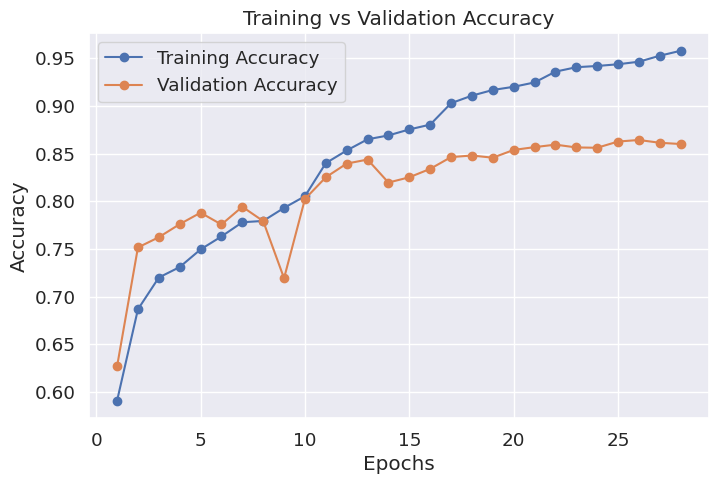

In [ ]:
# Plot for Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Accuracy")
plt.savefig('Accuracy_Graph.pdf')
files.download("Accuracy_Graph.pdf")
plt.show()


In [ ]:
# Plot for Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('Loss_Graph.pdf')
files.download("Loss_Graph.pdf")
plt.show()

NameError: name 'plt' is not defined

192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

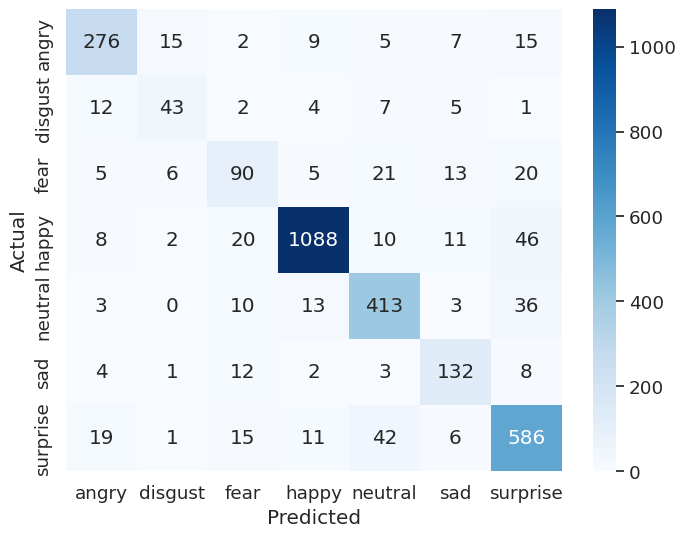

              precision    recall  f1-score   support

       angry       0.84      0.84      0.84       329
     disgust       0.63      0.58      0.61        74
        fear       0.60      0.56      0.58       160
       happy       0.96      0.92      0.94      1185
     neutral       0.82      0.86      0.84       478
         sad       0.75      0.81      0.78       162
    surprise       0.82      0.86      0.84       680

    accuracy                           0.86      3068
   macro avg       0.78      0.78      0.78      3068
weighted avg       0.86      0.86      0.86      3068



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


emotion_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Con_Graph.pdf')
files.download("Con_Graph.pdf")
plt.show()

# Print the classification report for detailed performance metrics
print(classification_report(y_true, y_pred, target_names=emotion_labels))


# **FER2013** Dataset From kaggle API

In [2]:
import kagglehub

FER_2013_DATASET_PATH = kagglehub.dataset_download("msambare/fer2013")

print(FER_2013_DATASET_PATH)

100%|██████████| 60.3M/60.3M [00:00<00:00, 114MB/s] 

Extracting files...


/root/.cache/kagglehub/datasets/msambare/fer2013/versions/1


## Data Pre-Processing for (FER2013)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = FER_2013_DATASET_PATH + '/train'
test_path = FER_2013_DATASET_PATH + '/test'

train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    rotation_range=20
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical',
    shuffle=True
)


test_datagen = ImageDataGenerator(rescale=1/255.0)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(100, 100),
    color_mode='grayscale',
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Training and Graph Generation

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    batch_size=16,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1795/1795 ━━━━━━━━━━━━━━━━━━━━ 425s 151ms/step - accuracy: 0.4043 - loss: 1.7965 - val_accuracy: 0.5479 - val_loss: 1.4518 - learning_rate: 0.0010
Epoch 2/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 157s 88ms/step - accuracy: 0.5282 - loss: 1.4816 - val_accuracy: 0.5745 - val_loss: 1.3758 - learning_rate: 0.0010
Epoch 3/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 157s 87ms/step - accuracy: 0.5598 - loss: 1.4142 - val_accuracy: 0.5821 - val_loss: 1.4167 - learning_rate: 0.0010
Epoch 4/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 158s 88ms/step - accuracy: 0.5761 - loss: 1.4142 - val_accuracy: 0.5832 - val_loss: 1.3938 - learning_rate: 0.0010
Epoch 5/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 199s 86ms/step - accuracy: 0.5922 - loss: 1.3765 - val_accuracy: 0.5958 - val_loss: 1.3986 - learning_rate: 0.0010
Epoch 6/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 157s 87ms/step - accuracy: 0.6232 - loss: 1.2922 - val_accuracy: 0.6300 - val_loss: 1.2375 - learning_rate: 5.0000e-04
Epoch 7/30
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 202s 87ms/step - accur

In [5]:
import matplotlib.pyplot as plt
from google.colab import files

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

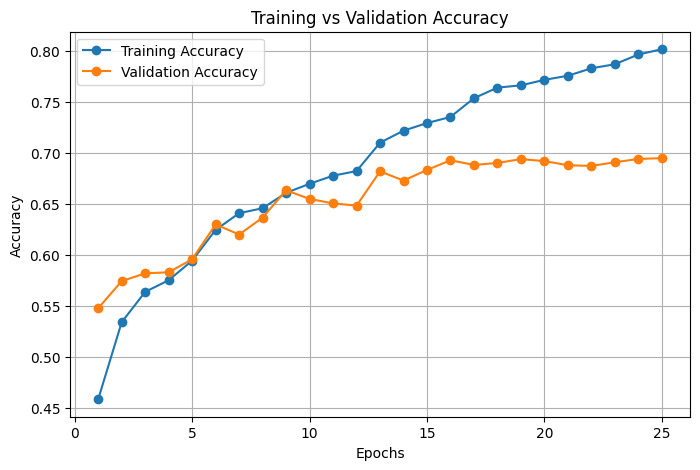

In [6]:
# Plot for Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Training vs Validation Accuracy")
plt.savefig('Accuracy_Graph.pdf')
files.download("Accuracy_Graph.pdf")
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

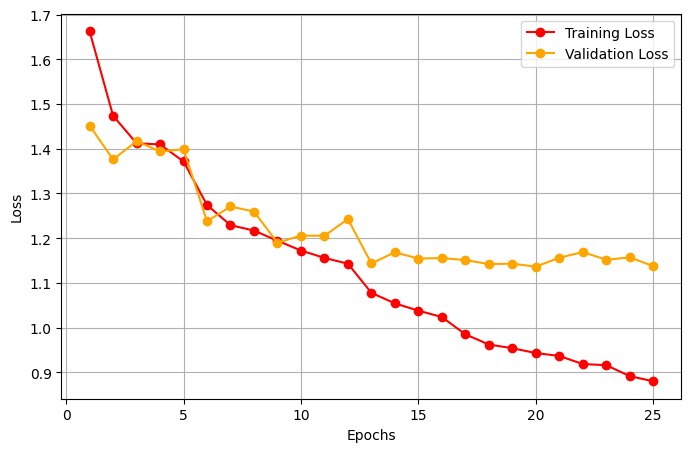

In [7]:
# Plot for Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('Loss_Graph.pdf')
files.download("Loss_Graph.pdf")
plt.show()

449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 59ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

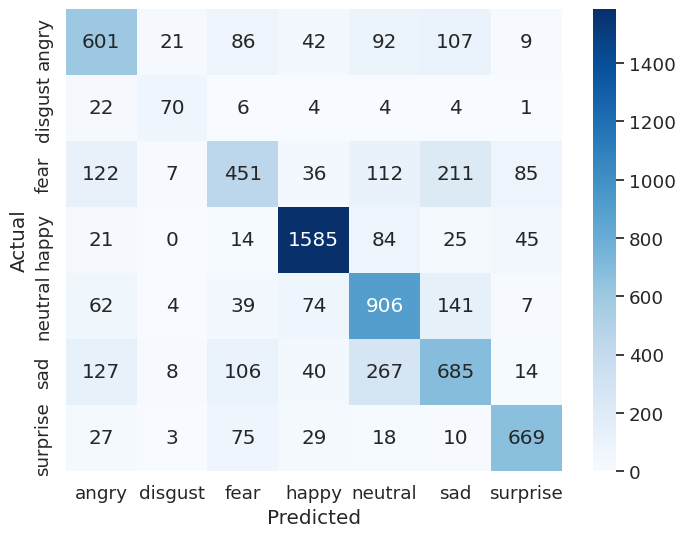

              precision    recall  f1-score   support

       angry       0.61      0.63      0.62       958
     disgust       0.62      0.63      0.62       111
        fear       0.58      0.44      0.50      1024
       happy       0.88      0.89      0.88      1774
     neutral       0.61      0.73      0.67      1233
         sad       0.58      0.55      0.56      1247
    surprise       0.81      0.81      0.81       831

    accuracy                           0.69      7178
   macro avg       0.67      0.67      0.67      7178
weighted avg       0.69      0.69      0.69      7178



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


emotion_labels = ['angry','disgust','fear','happy','neutral','sad','surprise']

y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('Con_Graph.pdf')
files.download("Con_Graph.pdf")
plt.show()

# Print the classification report for detailed performance metrics
print(classification_report(y_true, y_pred, target_names=emotion_labels))
